Suppose we have two trucking warehouses A and B separated by 200 miles. N trucks travel randomly between A and B with a 250 mile range and 500 kWh batteries. The warehouses are each equipped with C 100kW chargers. 

The trucks travel at 50 mph on average, so the average travel time T between the warehouses is $T_\text{travel} = \frac{\text{200 miles}}{\text{50 miles/h}} = 4$h.

The average down time for charging is $T_\text{down} = \frac{(\text{500 kWh})(\text{200 miles}) / \text{250 miles}}{\text{100 kW}} = 4$h.

1. Suppose a truck arrives at warehouse A and all C chargers are in use. What's the average wait time as a function of the number of chargers?

The probability that we're still waiting for a charger after time t is given by:

$$P_C(t) = (1-t/4h)^C$$

The average wait time is given by:

$$\mu_C = \int_0^\text{4h}tP_C(t)dt$$

which can be evaluated numerically

Text(0.5, 0, 'Number of chargers')

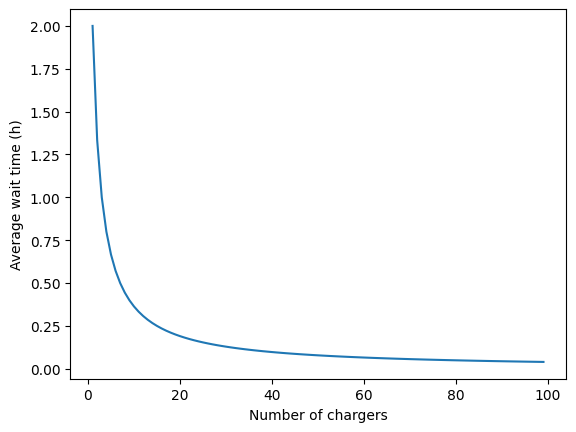

In [3]:
from scipy.integrate import quad
import numpy as np

ts = np.linspace(0, 4, 1000)

average_ts = []
Cs = np.arange(1,100)
for C in Cs:
    def P(t):
        return (1-t/4.)**C
    average_t, res = quad(P, 0, 4)
    average_ts.append(average_t)

import matplotlib.pyplot as plt

plt.plot(Cs, average_ts)
plt.ylabel('Average wait time (h)')
plt.xlabel('Number of chargers')

Now suppose there's a queue of Q other trucks waiting to charge. How does the average wait time vary as a function of C and Q?

If there's one truck in the queue, the newly arrived truck will need to wait $\mu_t$ on average for the truck ahead to start charging. The average wait time will then be:

$$\mu(Q=1) = \mu(Q=0) + \int_{\mu(Q=0)}^\text{4h}tP_{C-1}(t)dt$$

In general,

$$\mu(Q) = \mu(Q-1) + \int_{\mu(Q-1)}^\text{4h}tP_{C-Q}(t)dt$$


Text(0, 0.5, 'Average wait time (h)')

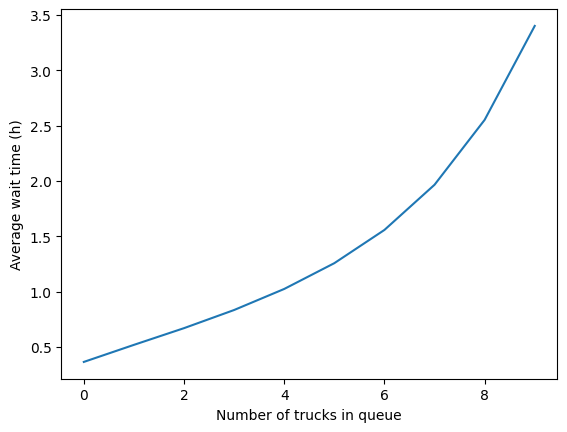

In [4]:
from scipy.integrate import quad
import numpy as np
ts = np.linspace(0, 4, 1000)

C = 10

mu_Qs = []
Qs = np.arange(0, C)
for Q in Qs:
    def P(t):
        return (1-t/4.)**C
    mu_0, res = quad(P, 0, 4)
    mu_last = mu_0
    mu_Q = mu_0
    for i in range(1, Q+1):  
        def P(t):
            return (1-t/4.)**(C-Q)
        mu_Q_int, res = quad(P, mu_last, 4)
        mu_Q = mu_last + mu_Q_int
        mu_last = mu_Q 
    mu_Qs.append(mu_Q)

plt.plot(Qs, mu_Qs)
plt.xlabel('Number of trucks in queue')
plt.ylabel('Average wait time (h)')
    

2. Now suppose that a truck arrives at warehouse A. If there are N trucks in total, what is the probability that there will be X other trucks there?

Neglecting additional time spent by other trucks waiting to charge at station B, the probability that there will be X other trucks at station A is given by the binomial probability:

$$P(\text{X at A}) = \binom{N-1}{X}\Big(\frac{1}{3}\Big)^X\Big(\frac{2}{3}\Big)^{N-1-X}$$

The average wait time is thus given by:

$$$$

where C is the number of chargers at each warehouse. 

In [7]:
# Make a plot of the average wait time as a function of N and C
import numpy as np
import scipy.special

Ns = np.arange(10)

def p_X_at_A(N, X):
    return scipy.special.binom(N-1, X) * (1./3.)**X * (2./3.)**(N-1-X)

for N in Ns:
    Cs = []
    t_waits = []
    for C in np.arange(N):
        print(N,C)
        Cs.append(C)
        i_s = np.arange(0, N-C)
        print(p_X_at_A(N, C+i_s))
        t_wait = np.sum(2+4*i_s)*p_X_at_A(N, C+i_s)
        t_waits.append(t_wait)
        
    print(t_waits)

[]
1 0
[1.]
[array([2.])]
2 0
[0.66666667 0.33333333]
2 1
[0.33333333]
[array([5.33333333, 2.66666667]), array([0.66666667])]
3 0
[0.44444444 0.44444444 0.11111111]
3 1
[0.44444444 0.11111111]
3 2
[0.11111111]
[array([8., 8., 2.]), array([3.55555556, 0.88888889]), array([0.22222222])]
4 0
[0.2962963  0.44444444 0.22222222 0.03703704]
4 1
[0.44444444 0.22222222 0.03703704]
4 2
[0.22222222 0.03703704]
4 3
[0.03703704]
[array([ 9.48148148, 14.22222222,  7.11111111,  1.18518519]), array([8.        , 4.        , 0.66666667]), array([1.77777778, 0.2962963 ]), array([0.07407407])]
5 0
[0.19753086 0.39506173 0.2962963  0.09876543 0.01234568]
5 1
[0.39506173 0.2962963  0.09876543 0.01234568]
5 2
[0.2962963  0.09876543 0.01234568]
5 3
[0.09876543 0.01234568]
5 4
[0.01234568]
[array([ 9.87654321, 19.75308642, 14.81481481,  4.9382716 ,  0.61728395]), array([12.64197531,  9.48148148,  3.16049383,  0.39506173]), array([5.33333333, 1.77777778, 0.22222222]), array([0.79012346, 0.09876543]), array([0.0